# Muscle modeling

Marcos Duarte

There are two major classes of muscle models that have been used in biomechanics and motor control: the Hill-type and Huxley-type models. They differ mainly on how the contractile element is modeled. In Hill-type models, the modeling of the contractile element is phenomenological; arbitrary mathematical functions are used to reproduce experimental observations relating muscle characteristics (such as excitation/activation, muscle length and velocity) with the muscle force. In Huxley-type models, the modeling of the contractile element is mechanistic; the mathematical functions used represent the hypothesized mechanisms for the cross-bridge dynamics (Tsianos and Loeb, 2013). Huxley-type models tend to produce more realistic results than Hill-type models for certain conditions but they have a higher computational demand. For this reason, Hill-type models are more often employed in musculoskeletal modeling and simulation. 

Hill-type muscle models are presented in several texts (e.g., Erdermir et al. 2007; He et al., 1991; McMahon, 1984; Nigg and Herzog, 2007; Robertson et al., 2013, Thelen, 2003; Tsianos and Loeb, 2013, Winters, 1990; Zajac, 1989; Zatsiorsky and Prilutsky, 2012) and implemented in many software for modeling and simulation of the musculoskeletal dynamics of human movement (e.g., the free and open source software [OpenSim](https://simtk.org/home/opensim)).  

Next, let's see a brief overview of a Hill-type muscle model and a basic implementation in Python. 

## Hill-type muscle model

Hill-type models are developed to reproduce the dependence of force with the length and velocity of the muscle-tendon unit and parameters are lumped and made dimensionless in order to represent different muscles with few changes in these parameters. A Hill-type model is complemented with the modeling of the activation dynamics (i.e., the temporal pattern of muscle activation and deactivation as a function of the neural excitation) to produce more realistic results. As a result, the force generated will be a function of three factors: the length and velocity of the muscle-tendon unit and its activation level $a$. 

A Hill-type muscle model has three components (see figure below): two for the muscle, an active contractile element (CE) and a passive elastic element (PE) in parallel with the CE, and one component for the tendon, an elastic element (SE) in series with the muscle. In some variations, a damping component is added parallel to the CE as a fourth element. A [pennation angle](http://en.wikipedia.org/wiki/Muscle_architecture) (angle of the pennate fibers with respect to the force-generating axis) is also included in the model. In a simpler approach, the muscle and tendon are assumed massless.

<figure><img src="./../images/muscle_hill.png" width=400 alt="Hill-type muscle model."/><figcaption><center><i>Figure. A Hill-type muscle model with three components: two for the muscle, an active contractile element, $\mathsf{CE}$, and a passive elastic element in parallel, $\mathsf{PE}$, with the $\mathsf{CE}$, and one component for the tendon, an elastic element in series, $\mathsf{SE}$, with the muscle. $\mathsf{L_{MT}}$: muscle–tendon length, $\mathsf{L_T}$: tendon length, $\mathsf{L_M}$: muscle fiber length, $\mathsf{F_T}$: tendon force, $\mathsf{F_M}$: muscle force, and $α$: pennation angle.</i></center></figcaption>

Let's now revise the models of a Hill-type muscle with three components and activation dynamics by two references:  
 1. [Thelen (2003)](http://simtk-confluence.stanford.edu:8080/display/OpenSim/Thelen+2003+Muscle+Model) with some of the adjustments described in Millard et al. (2013). Hereafter, Thelen2003Muscle or T03.
 2. [McLean, Su, van den Bogert (2003)](http://www.ncbi.nlm.nih.gov/pubmed/14986412). Hereafter, McLean2003Muscle or M03.
 
First, let's import the necessary Python libraries and customize the environment:

In [1]:
import numpy as np
from scipy.integrate import ode, odeint
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib nbagg 
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.size'] = 13
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rc('axes', grid=True, labelsize=14, titlesize=16, ymargin=0.05)
matplotlib.rc('legend', numpoints=1, fontsize=11)

### Force-length relationship

In a Hill-type model, the force a muscle can generate depends on its length due to two factors:  

1. The active force of the contractile element (CE), which in turn depends on the spatial superposition of the actin and myosin molecules to form cross-bridges at the sarcomere. A maximum number of cross-bridges will be formed at an optimal fiber length, generating a maximum force. When a fiber is too stretched or too shortened, fewer cross-bridges will be formed, decreasing the force generated.  
2. The passive and parallel elastic element (PE), which behaves as a nonlinear spring where no force is generated below a certain length (the slack length) and force increases with the muscle elongation.

#### Force-length relationship of the contractile element

Thelen2003Muscle represented the normalized force-length relationship of the contractile element by a Gaussian function:

$$ \bar{f}_{l,CE} = exp\left[-(\bar{L}_M-1)^2/\gamma\right] $$

where $\gamma$ is a shape factor and $\bar{L}_M$ is the muscle fiber length normalized by the optimal muscle fiber length at which maximal force can be produced, $L_{Mopt}$:

$$\bar{L}_M=\frac{L_M}{L_{Mopt}}$$

Thelen2003Muscle adopted $\gamma=0.45$. The actual force produced is obtained multiplying $\bar{f}_{l,CE}$ by the maximum isometric muscle force, $F_{M0}$. Thelen2003Muscle assumed that the maximum isometric muscle forces for old adults were 30% lower than those used for young adults.

McLean2003Muscle represented the force-length relationship of the contractile element (not normalized) as a function of muscle length (not normalized) by a quadratic function:

$$ 
f_{l,CE} = max \left\{ 
  \begin{array}{l l}
    F_{Mmin} \\
    F_{M0}\left[1 - \left(\frac{L_M-L_{Mopt}}{WL_{Mopt}}\right)^2\right]
\end{array} \right.
$$

where $W$ is a dimensionless parameter describing the width of the force-length relationship. A minimum force level $F_{Mmin}$ is employed for numerical stability.   
McLean2003Muscle adopted $W=1$ and $F_{Mmin}=10 N$. 

The corresponding Python functions are:

In [2]:
def flce_T03(lm=1, gammal=0.45):
    """Thelen (2003) force of the contractile element as function of muscle length.
    
    Parameters
    ----------
    lm  : float, optional (default=1)
        normalized muscle fiber length
    gammal  : float, optional (default=0.45)
        shape factor

    Returns
    -------
    fl  : float
        normalized force of the muscle contractile element
    """
    
    fl = np.exp(-(lm-1)**2/gammal)
    
    return fl

In [3]:
def flce_M03(lm=1, lmopt=1, fm0=1, fmmin=0.001, wl=1):
    """McLean (2003) force of the contractile element as function of muscle length.
    
    Parameters
    ----------
    lm  : float, optional (default=1)
        muscle (fiber) length
    lmopt  : float, optional (default=1)
        optimal muscle fiber length
    fm0  : float, optional (default=1)
        maximum isometric muscle force
    fmmin  : float, optional (default=0.001)
        minimum muscle force
    wl  : float, optional (default=1)
        shape factor of the contractile element force-length curve

    Returns
    -------
    fl  : float
        force of the muscle contractile element
    """
    
    fl = np.max([fmmin, fm0*(1 - ((lm - lmopt)/(wl*lmopt))**2)])
    
    return fl

And plots of these functions:

In [4]:
lm = np.arange(0, 2.02, .02)
fce_T03 = np.zeros(lm.size)
fce_M03 = np.zeros(lm.size)
for i in range(len(lm)):
    fce_T03[i] = flce_T03(lm[i])
    fce_M03[i] = flce_M03(lm[i])

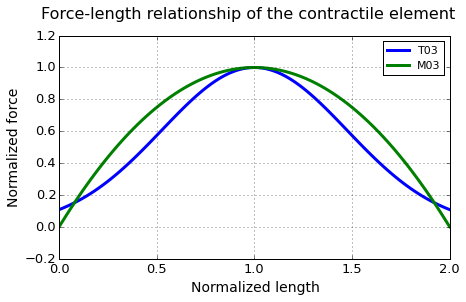

In [5]:
plt.figure(figsize=(7, 4))
plt.plot(lm, fce_T03, 'b', label='T03')
plt.plot(lm, fce_M03, 'g', label='M03')
plt.xlabel('Normalized length')
plt.ylabel('Normalized force')
plt.legend(loc='best')
plt.suptitle('Force-length relationship of the contractile element', y=1, fontsize=16)
plt.show()

Similar results when the same parameters are used.

#### Force-length relationship of the parallel element

Thelen2003Muscle represents the normalized force of the parallel (passive) element of the muscle as a function of muscle length (normalized by the optimal muscle fiber length) by an exponential function:

$$ \bar{F}_{PE}(\bar{L}_M) = \frac{exp\left[k_{PE}(\bar{L}_M-1)/\epsilon_{M0}\right]-1}{exp(k_{PE})-1} $$

where $k_{PE}$ is an exponential shape factor and $\epsilon_{M0}$ is the passive muscle strain due to maximum isometric force:

$$\epsilon_{M0}=\frac{L_M(F_{M0})-L_{Mslack}}{L_{Mslack}}$$

where $L_{Mslack}$ is the muscle slack length. Thelen2003Muscle adopted $L_{Mslack} = L_{Mopt}$.   
Thelen2003Muscle adopted $k_{PE}=5$ and $\epsilon_{M0}=0.6$ for young adults ($\epsilon_{M0}=0.5$ for old adults). The actual force produced is obtained multiplying $\bar{F}_{PE}$ by the maximum isometric muscle force, $F_{M0}$.

McLean2003Muscle represents the force of the parallel (passive) element of the muscle (not normalized) as a function of muscle length (not normalized) by a quadratic function:

$$ 
F_{PE}(L_M) = \left\{ 
  \begin{array}{l l}
    0 \quad & \text{if} \quad L_M \leq L_{Mslack} \\
    k_{PE}(L_M - L_{Mslack})^2 \quad & \text{if} \quad L_M > L_{Mslack}
\end{array} \right.
$$

where $k_{PE}$ is a stiffness parameter of the parallel element such that the passive muscle force is equal to the normalized maximum isometric force of the muscle when the CE is stretched to its maximal length for active force production:

$$ k_{PE} = \frac{F_{M0}}{(WL_{Mopt})^2} $$

McLean2003Muscle adopted $L_{Mslack} = L_{Mopt}$.

The corresponding Python functions are:

In [6]:
def fpelm_T03(lm=1, kpe=5, epsm0=0.6):
    """Thelen (2003) force of the muscle parallel element as function of muscle length.
    
    Parameters
    ----------
    lm  : float, optional (default=1)
        normalized muscle fiber length
    kpe  : float, optional (default=5)
        exponential shape factor
    epsm0  : float, optional (default=0.6)
        passive muscle strain due to maximum isometric force

    Returns
    -------
    fpe  : float
        normalized force of the muscle parallel (passive) element
    """
    
    if lm < 1:
        fpe = 0
    else:
        fpe = (np.exp(kpe*(lm-1)/epsm0)-1)/(np.exp(kpe)-1)
    
    return fpe

In [7]:
def fpelm_M03(lm=1, lmopt=1, fm0=1, lmslack=1, wp=1):
    """McLean (2003) force of the muscle parallel element as function of muscle length.
    
    Parameters
    ----------
    lm  : float, optional (default=1)
        muscle fiber length
    lmopt  : float, optional (default=1)
        optimal muscle (fiber) length
    fm0  : float, optional (default=1)
        maximum isometric muscle force
    lmslack  : float, optional (default=1)
        muscle slack length
    wp  : float, optional (default=1)
        shape factor of the parallel element force-length curve

    Returns
    -------
    fpe  : float
        force of the muscle parallel (passive) element
    """
    
    kpe = fm0/(wp*lmopt)**2
    if lm <= lmslack:
        fpe = 0
    else:
        fpe = kpe*(lm-lmslack)**2
        
    return fpe

And plots of these functions:

In [8]:
lm = np.arange(0, 2.02, .02)
fpe_T03 = np.zeros(lm.size)
fpe_M03 = np.zeros(lm.size)
for i in range(len(lm)):
    fpe_T03[i] = fpelm_T03(lm[i])
    fpe_M03[i] = fpelm_M03(lm[i])

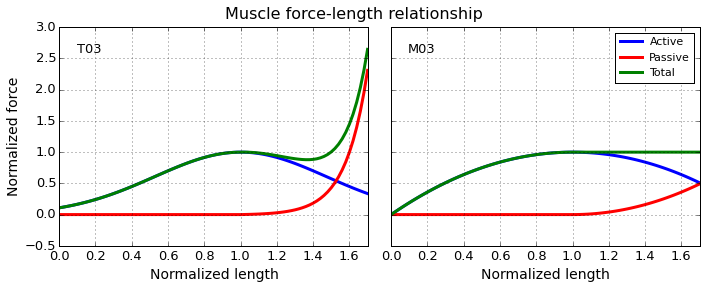

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 4))
ax1.plot(lm[:86], fce_T03[:86], 'b', label='Active')
ax1.plot(lm[:86], fpe_T03[:86], 'r', label='Passive')
ax1.plot(lm[:86], fce_T03[:86] + fpe_T03[:86], 'g', label='Total')
ax1.text(0.1, 2.6, 'T03')
ax1.set_xlim([0, 1.7])
ax1.set_xlabel('Normalized length')
ax1.set_ylabel('Normalized force')
#ax1.legend(loc='best')
ax2.plot(lm[:86], fce_M03[:86], 'b', label='Active')
ax2.plot(lm[:86], fpe_M03[:86], 'r', label='Passive')
ax2.plot(lm[:86], fce_M03[:86] + fpe_M03[:86], 'g', label='Total')
ax2.text(0.1, 2.6, 'M03')
ax2.set_xlim([0, 1.7])
ax2.set_xlabel('Normalized length')
ax2.legend(loc='best')
plt.suptitle('Muscle force-length relationship', y=1, fontsize=16)
plt.tight_layout()
plt.show()

The results are different at the maximum stretching because Thelen2003Muscle and McLean2003Muscle model differently the passive component.   
These results were simulated for a maximum muscle activation (an activation level, $a$, of 1, where 0 is no activation). The effect of different activation levels on the total muscle force (but only the active force is affected) is shown in the next figure:

In [10]:
lm = np.arange(0, 2.02, .02)
fce_T03_als = np.zeros((lm.size, 5))
als = [0, 0.25, 0.50, 0.75, 1.0]
for j, al in enumerate(als):
    for i in range(len(lm)):
        fce_T03_als[i, j] = flce_T03(lm[i])*al

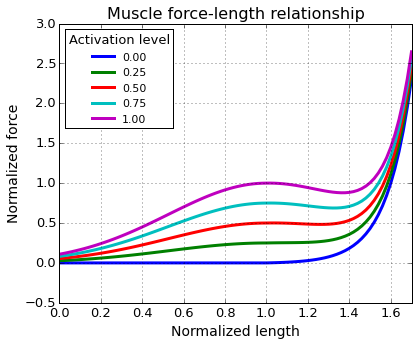

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(6, 5))
for j, al in enumerate(als):
    ax.plot(lm[:86], fce_T03_als[:86, j] + fpe_T03[:86], label='%.2f'%al)
ax.text(0.1, 2.6, 'T03')
ax.set_xlim([0, 1.7])
ax.set_xlabel('Normalized length')
ax.set_ylabel('Normalized force')
ax.legend(loc='best', title='Activation level')
ax.set_title('Muscle force-length relationship', y=1, fontsize=16)
plt.tight_layout()
plt.show()

#### Force-length relationship of the series element (tendon)

Thelen2003Muscle represented the tendon force of the series element as a function of the normalized tendon length (in fact, tendon strain) by an exponential function during an initial nonlinear toe region and by a linear function thereafter:

$$ 
\bar{F}_{SE}(\bar{L}_T) = \left\{ 
  \begin{array}{l l}
    \frac{\bar{F}_{Ttoe}}{exp(k_{Ttoe})-1}\left[exp(k_{Ttoe}\epsilon_T/\epsilon_{Ttoe})-1\right] \quad & \text{if} \quad \epsilon_T \leq \epsilon_{Ttoe} \\
    k_{Tlin}(\epsilon_T - \epsilon_{Ttoe}) + \bar{F}_{Ttoe} \quad & \text{if} \quad \epsilon_T > \epsilon_{Ttoe}
\end{array} \right.
$$

where $\epsilon_{T}$ is the tendon strain:

$$\epsilon_{T} = \frac{L_T-L_{Tslack}}{L_{Tslack}}$$

$L_{Tslack}$ is the tendon slack length, $\epsilon_{Ttoe}$ is the tendon strain above which the tendon exhibits linear behavior, $k_{Ttoe}$ is an exponential shape factor, and $k_{Tlin}$ is a linear scale factor. The parameters are chosen such that the tendon elongation at the normalized maximal isometric force of the muscle is 4% of the tendon length ($\epsilon_{T0}=0.04$).  
Thelen2003Muscle adopted $k_{Ttoe}=3$ and the transition from nonlinear to linear behavior occurs for normalized tendon forces greater than $\bar{F}_{Ttoe}=0.33$. For continuity of slopes at the transition, $\epsilon_{Ttoe}=0.609\epsilon_{T0}$ and $k_{Tlin}=1.712/\epsilon_{T0}$. The actual force produced is obtained multiplying $\bar{F}_{SE}$ by the maximum isometric muscle force, $F_{M0}$.

McLean2003Muscle represented the tendon force (not normalized) of the series element as a function of the tendon length (not normalized) by the same quadratic function used for the force of the muscle passive element:

$$ 
F_{SE}(L_T) = \left\{ 
  \begin{array}{l l}
    0 \quad & \text{if} \quad L_T \leq L_{Tslack} \\
    k_T(L_T - L_{Tslack})^2 \quad & \text{if} \quad L_T > L_{Tslack}
\end{array} \right.
$$

where $k_T$ is the tendon stiffness. The stiffness parameter $k_T$ is chosen such that the tendon elongation is 4% at the maximum isometric force, $k_T=(1/\epsilon_{T0})^2=625$ for $F_{M0}=1$.

The corresponding Python functions are:

In [12]:
def fselt_T03(lt=1, ltslack=1, epst0=0.04, kttoe=3):
    """Thelen (2003) force-length relationship of tendon as function of tendon length.
    
    Parameters
    ----------
    lt  : float, optional (default=1)
        normalized tendon length
    ltslack  : float, optional (default=1)
        normalized tendon slack length
    epst0  : float, optional (default=0.04)
        tendon strain at the maximal isometric muscle force
    kttoe  : float, optional (default=3)
        linear scale factor

    Returns
    -------
    fse  : float
        normalized force of the tendon series element
    """

    epst = (lt-ltslack)/ltslack
    fttoe = 0.33
    # values from OpenSim Thelen2003Muscle
    epsttoe =  .99*epst0*np.e**3/(1.66*np.e**3 - .67)
    ktlin =  .67/(epst0 - epsttoe)
    #
    if epst <= 0:
        fse = 0
    elif epst <= epsttoe:
        fse = fttoe/(np.exp(kttoe)-1)*(np.exp(kttoe*epst/epsttoe)-1)
    else:
        fse = ktlin*(epst-epsttoe) + fttoe
        
    return fse

In [13]:
def fselt_M03(lt, ltslack=1, fm0=1, epst0=0.04):
    """McLean (2003) force-length relationship of tendon as function of tendon length.
    
    Parameters
    ----------
    lt  : float, optional (default=1)
        tendon length
    ltslack  : float, optional (default=1)
        tendon slack length
    fm0  : float, optional (default=1)
        maximum isometric muscle force
    epst0  : float, optional (default=0.04)
        tendon strain at the maximal isometric muscle force

    Returns
    -------
    fse  : float
        force of the tendon series element
    """

    kt = fm0/epst0**2
    if lt <= ltslack:
        fse = 0
    else:
        fse = kt*(lt-ltslack)**2
        
    return fse

And plots of these functions:

In [14]:
lt = np.arange(1, 1.051, .001)
fse_T03 = np.zeros(lt.size)
fse_M03 = np.zeros(lt.size)
for i in range(len(lt)):
    fse_T03[i] = fselt_T03(lt[i])
    fse_M03[i] = fselt_M03(lt[i])

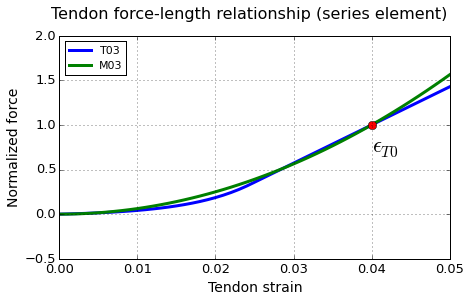

In [15]:
plt.figure(figsize=(7, 4))
plt.plot(lt-1, fse_T03, 'b', label='T03')
plt.plot(lt-1, fse_M03, 'g', label='M03')
plt.plot(0.04, 1, 'ro', markersize=8)
plt.text(0.04, 0.7, '$\epsilon_{T0}$', fontsize=22)
plt.xlabel('Tendon strain')
plt.ylabel('Normalized force')
plt.legend(loc='upper left')
plt.suptitle('Tendon force-length relationship (series element)', y=1, fontsize=16)
plt.show()

Similar results when the same parameters are used.

### Force-velocity relationship of the contractile element

The force-velocity relation of the contractile element for shortening (concentric activation) is based on the well known Hill's equation of a hyperbola describing that the product between force $F$ and velocity $V$ of the contractile element is constant (Winters, 1990; Winters, 1995):

$$ (F+a')(V+b') = (F_{0}+a')b' $$

where $a'$, $b'$, and $F_{0}$ are constants.  

We can rewrite the equation above with constants more meaningful to our modeling: 

$$ (F_{M}+A_f F_{Mlen})(V_M+A_f V_{Mmax}) = A_f F_{Mlen}V_{Mmax}(1+A_f) $$

where $F_{M}$ and $V_M$ are the contractile element force and velocity, respectively, and the three constants are: $V_{Mmax}$, the maximum unloaded velocity (when $F_{M}=0$), $F_{Mlen}$, the maximum isometric force (when $V_M=0$), and $A_f$, a shape factor which specifies the concavity of the hyperbola.

Based on the equation above for the shortening phase and in Winters (1990, 1995) for the lengthening phase, Thelen2003Muscle employed the following force-velocity equation:

$$ V_M = (0.25+0.75a)\,V_{Mmax}\frac{\bar{F}_M-a\bar{f}_{l,CE}}{b}  $$

where

$$ 
b = \left\{ 
  \begin{array}{l l l}
    a\bar{f}_{l,CE} + \bar{F}_M/A_f \quad & \text{if} \quad \bar{F}_M \leq a\bar{f}_{l,CE} & \text{(shortening)} \\
    \\
    \frac{(2+2/A_f)(a\bar{f}_{l,CE}\bar{f}_{Mlen} - \bar{F}_M)}{\bar{f}_{Mlen}-1} \quad & \text{if} \quad \bar{F}_M > a\bar{f}_{l,CE} & \text{(lengthening)} 
\end{array} \right.
$$ 

where $a$ is the activation level and $\bar{f}_{Mlen}$ is a constant for the maximum force generated at the lengthening phase (normalized by the maximum isometric force).   
Thelen2003Muscle adopted $A_f=0.25$, $V_{Mmax}=10L_{Mopt}/s$, $\bar{f}_{Mlen}=1.4$ for young adults ($V_{Mmax}=8L_{Mopt}/s$ and $\bar{f}_{Mlen}=1.8$ for old adults). Note that the dependences of the force with the activation level and with the muscle length are already incorporated in the expression above. 

McLean2013Muscle employed:

$$ 
\bar{f}_{v,CE} = \left\{ 
  \begin{array}{l l l}
    \frac{\lambda(a)V_{Mmax} + V_M}{\lambda(a)V_{Mmax} - V_M/A_f} \quad & \text{if} \quad V_M \leq 0 & \text{(shortening)} \\
    \\
    \frac{\bar{f}_{Mlen}V_M + d_1}{V_M + d_1} \quad & \text{if} \quad 0 < V_M \leq \gamma d_1 & \text{(slow lengthening)} \\
    \\
    d_3 + d_2V_M \quad & \text{if} \quad V_M > \gamma d_1 & \text{(fast lengthening)} 
\end{array} \right.
$$ 

where

$$ \begin{array}{l l}
    \lambda(a) = 1-e^{-3.82a} + a\:e^{-3.82} \\
    \\
    d_1 = \frac{V_{Mmax}A_f(\bar{f}_{Mlen}-1)}{S(A_f+1)} \\
    \\
    d_2 = \frac{S(A_f+1)}{V_{Mmax}A_f(\gamma+1)^2} \\
    \\
    d_3 = \frac{(\bar{f}_{Mlen}-1)\gamma^2}{(\gamma+1)^2} + 1
\end{array} $$

where $\lambda(a)$ is a scaling factor to account for the influence of the activation level $a$ on the force-velocity relationship, $\bar{f}_{Mlen}$ is the asymptotic (maximum) value of $\bar{F}_M$, $S$ is a parameter to double the slope of the force-velocity curve at zero velocity, and $\gamma$ is a dimensionless parameter to ensure the transition between the hyperbolic and linear parts of the lengthening phase.  
McLean2013Muscle adopted $A_f=0.25$, $V_{Mmax}=10L_{Mopt}/s$, $\bar{f}_{Mlen}=1.5$, $S=2.0$, and $\gamma=5.67$.

Let's write these expressions as Python code and visualize them:

In [16]:
def vmfce_T03(fm, flce=1, lmopt=1, a=1, vmmax=1, fmlen=1.4, af=0.25):
    """Thelen (2003) velocity of the force-velocity relationship as function of CE force.
    
    Parameters
    ----------
    fm  : float
        normalized muscle force
    flce  : float, optional (default=1)
        normalized muscle force due to the force-length relationship
    lmopt  : float, optional (default=1)
        optimal muscle fiber length
    a  : float, optional (default=1)
        muscle activation level
    vmmax  : float, optional (default=1)
        maximum muscle velocity for concentric activation
    fmlen  : float, optional (default=1.4)
        normalized maximum force generated at the lengthening phase
    af  : float, optional (default=0.25)
        shape factor

    Returns
    -------
    vm  : float
        velocity of the muscle
    """
    
    vmmax = vmmax*lmopt
    if fm <= a*flce:  # isometric and concentric activation
        b = a*flce + fm/af
    else:             # eccentric activation
        b = (2 + 2/af)*(a*flce*fmlen - fm)/(fmlen - 1) 
    vm = (0.25  + 0.75*a)*vmmax*(fm - a*flce)/b
    
    return vm

Let's find an expression for contractile element force as function of muscle velocity given the equation above, i.e. we want to invert the equation. For that, let's use [Sympy](http://www.sympy.org/):

In [17]:
def fvce_T03_symb():
    # Thelen (2003) velocity of the force-velocity relationship as function of CE force
    
    from sympy import symbols, solve, collect, Eq
    a, flce, fm, af, fmlen, vmmax = symbols('a, flce, fm, af, fmlen, vmmax', positive=True)
    vm = symbols('vm', real=True)
    
    b = a*flce + fm/af
    vm_eq = Eq(vm - (0.25 + 0.75*a)*vmmax*(fm - a*flce)/b)
    sol = solve(vm_eq, fm)
    print('fm <= a*flce:\n', collect(sol[0], vmmax),'\n')
    
    b = (2 + 2/af)*(a*flce*fmlen - fm)/(fmlen - 1)
    vm_eq = Eq(vm - (0.25 + 0.75*a)*vmmax*(fm - a*flce)/b)
    sol = solve(vm_eq, fm)
    print('fm > a*flce:\n', collect(sol[0], (vmmax*af, fmlen, vm)))

fvce_T03_symb()

fm <= a*flce:
 a*af*flce*(4.0*vm + vmmax*(3.0*a + 1))/(-4.0*vm + vmmax*(3.0*a*af + af)) 

fm > a*flce:
 a*flce*(af*vmmax*(3.0*a*fcemax - 3.0*a + fcemax - 1) + fcemax*(8.0*af*vm + 8.0*vm))/(af*vmmax*(3.0*a*fcemax - 3.0*a + fcemax - 1) + vm*(8.0*af + 8.0))


And here is the function we need to compute contractile element force as function of muscle velocity:

In [18]:
def fvce_T03(vm=0, flce=1, lmopt=1, a=1, vmmax=1, fmlen=1.4, af=0.25):
    """Thelen (2003) force of the contractile element as function of muscle velocity.
    
    Parameters
    ----------
    vm  : float, optional (default=0)
        muscle velocity
    flce  : float, optional (default=1)
        normalized muscle force due to the force-length relationship
    lmopt  : float, optional (default=1)
        optimal muscle fiber length
    a  : float, optional (default=1)
        muscle activation level
    vmmax  : float, optional (default=1)
        maximum muscle velocity for concentric activation
    fmlen  : float, optional (default=1.4)
        normalized maximum force generated at the lengthening phase
    af  : float, optional (default=0.25)
        shape factor

    Returns
    -------
    fvce  : float
        normalized force of the muscle contractile element
    """

    vmmax = vmmax*lmopt
    if vm <= 0:  # isometric and concentric activation
        fvce = af*a*flce*(4*vm + vmmax*(3*a + 1))/(-4*vm + vmmax*af*(3*a + 1))
    else:        # eccentric activation
        fvce = a*flce*(af*vmmax*(3*a*fmlen - 3*a + fmlen - 1) + 8*vm*fmlen*(af + 1))/\
               (af*vmmax*(3*a*fmlen - 3*a + fmlen - 1) + 8*vm*(af + 1))
    
    return fvce

Here is the Python function for the McLean (2003) model:

In [19]:
def fvce_M03(vm=0, lmopt=1, a=1, vmmax=1, fmlen=1.5, af=0.25, s=2, gammav=5.67):
    """McLean (2003) contractile element force as function of muscle velocity.
    
    Parameters
    ----------
    vm  : float, optional (default=0)
        muscle velocity
    lmopt  : float, optional (default=1)
        optimal muscle fiber length
    a  : float, optional (default=1)
        muscle activation level
    vmmax  : float, optional (default=1)
        maximum muscle velocity for concentric activation
    fmlen  : float, optional (default=1.5)
        normalized maximum force generated at the lengthening phase
    af  : float, optional (default=0.25)
        shape factor
    s  : float, optional (default=2)
        to double the slope of the force-velocity curve at zero velocity
    gammav  : float, optional (default=5.67)
        to ensure the smooth transition of the lengthening phase

    Returns
    -------
    fvce  : float
        normalized force of the muscle contractile element
    """

    vmmax = vmmax*lmopt
    d1 = vmmax*af*(fmlen - 1)/(s*(af + 1))
    d2 = s*(af + 1)/(vmmax*af*(gammav + 1)**2)
    d3 = (fmlen - 1)*gammav**2/(gammav + 1)**2 + 1
    lbd = 1 - np.exp(-3.82*a) + a*np.exp(-3.82)
    if vm <= 0:                # isometric and concentric activation
        fvce = (lbd*vmmax + vm)/(lbd*vmmax - vm/af)
    elif 0 < vm <= gammav*d1:  # slow lengthening
        fvce = (fmlen*vm + d1)/(vm + d1)
    elif vm > gammav*d1:       # fast lengthening
        fvce = d3 + d2*vm
    
    return fvce

We can invert this equation to get an expression for muscle velocity as function of the contractile element force:

In [20]:
def vmfce_M03(fvce=1, lmopt=1, a=1, vmmax=1, fmlen=1.5, af=0.25, s=2, gammav=5.67):
    """McLean (2003) contractile element velocity as function of CE force.
    
    Parameters
    ----------
    fvce  : float, optional (default=1)
        normalized muscle force
    lmopt  : float, optional (default=1)
        optimal muscle fiber length
    a  : float, optional (default=1)
        muscle activation level
    vmmax  : float, optional (default=1)
        maximum muscle velocity for concentric activation
    fmlen  : float, optional (default=1.5)
        normalized maximum force generated at the lengthening phase
    af  : float, optional (default=0.25)
        shape factor
    s  : float, optional (default=2)
        to double the slope of the force-velocity curve at zero velocity
    gammav  : float, optional (default=5.67)
        to ensure the smooth transition of the lengthening phase

    Returns
    -------
    fvce  : float
        muscle velocity
    """
    
    vmmax = vmmax*lmopt
    d1 = vmmax*af*(fmlen - 1)/(s*(af + 1))
    d2 = s*(af + 1)/(vmmax*af*(gammav + 1)**2)
    d3 = (fmlen - 1)*gammav**2/(gammav + 1)**2 + 1
    lbd = 1 - np.exp(-3.82*a) + a*np.exp(-3.82)
    if 0 <= fvce <= 1:                   # isometric and concentric activation
        vm = (lbd*vmmax*(1 - fvce))/(1 + fvce/af)
    elif 1 < fvce <= gammav*d1*d2 + d3:  # slow lengthening
        vm = d1*(fvce - 1)/(fmlen - fvce)
    elif fvce > gammav*d1*d2 + d3:       # fast lengthening
        vm = (fvce - d3)/d2
    
    return vm

Let's use these functions to compute muscle force as a function of the muscle velocity considering two levels of activation:

In [21]:
vm1_T03 = np.linspace(-1, 1, 201)
fce1_T03 = np.zeros(vm1_T03.size)
vm2_T03 = np.linspace(-.63, .63, 201)
fce2_T03 = np.zeros(vm2_T03.size)
for i in range(len(vm1_T03)):
    fce1_T03[i] = fvce_T03(vm=vm1_T03[i])
    fce2_T03[i] = fvce_T03(vm=vm2_T03[i], a=0.5)

In [22]:
vm1_M03 = np.linspace(-1, 1, 201)
fce1_M03 = np.zeros(vm1_M03.size)
vm2_M03 = np.linspace(-.63, .63, 201)
fce2_M03 = np.zeros(vm2_M03.size)
for i in range(len(vm1_M03)):
    fce1_M03[i] = fvce_M03(vm=vm1_M03[i])
    fce2_M03[i] = fvce_M03(vm=vm2_M03[i], a=0.5)
fce2_M03 = fce2_M03*0.5

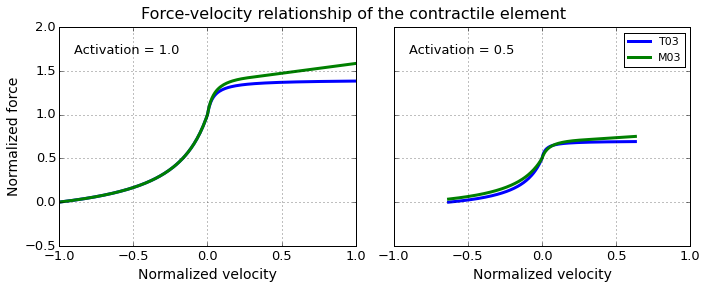

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 4))
ax1.plot(vm1_T03, fce1_T03, 'b', label='T03)')
ax1.plot(vm1_M03, fce1_M03, 'g', label='M03)')
ax1.set_ylabel('Normalized force')
ax1.set_xlabel('Normalized velocity')
ax1.text(-.9, 1.7, 'Activation = 1.0')
ax2.plot(vm2_T03, fce2_T03, 'b', label='T03')
ax2.plot(vm2_M03, fce2_M03, 'g', label='M03')
ax2.text(-.9, 1.7, 'Activation = 0.5')
ax2.set_xlabel('Normalized velocity')
ax2.legend(loc='best')
plt.suptitle('Force-velocity relationship of the contractile element', y=1, fontsize=16)
plt.tight_layout()
plt.show()

Identical results for the shortening phase when $a=1$ and similar results for the lengthening phase when the same parameters are used.

#### Muscle power

The muscle power is the product between force and velocity:

In [24]:
P_T03 = np.abs(fce1_T03*vm1_T03)

Let's visualize the muscle power only for the concentric phase (muscle shortening):

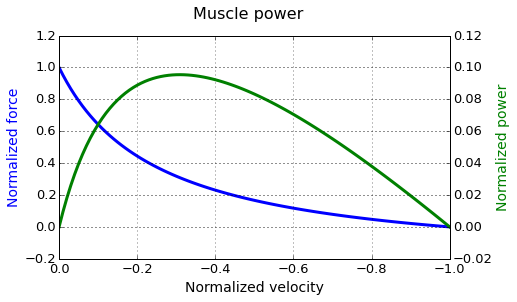

In [25]:
plt.figure(figsize=(7, 4))
plt.plot(vm1_T03[:101], fce1_T03[:101], 'b', label='Force')
plt.xlabel('Normalized velocity')
plt.ylabel('Normalized force', color='b')
#plt.legend(loc='upper left')
plt.gca().invert_xaxis()
plt.gca().twinx()
plt.plot(vm1_T03[:101], P_T03[:101], 'g', label='Power')
plt.ylabel('Normalized power', color='g')
#plt.legend(loc='upper right')
plt.suptitle('Muscle power', y=1, fontsize=16)
plt.show()

#### Force-length-velocity relationship

Let's visualize the effects of the length and velocity on the total (active plus passive) muscle force:

In [26]:
lms = np.linspace(0, 1.65, 101)
vms = np.linspace(-1, .76, 101)
fce_T03 = np.zeros(lms.size)
fpe_T03 = np.zeros(lms.size)
fm_T03 = np.zeros((lms.size, vms.size))
for i in range(len(lms)):
    fce_T03[i] = flce_T03(lm=lms[i])
    fpe_T03[i] = fpelm_T03(lm=lms[i])  
    for j in range(len(vms)):
        fm_T03[j, i] = fvce_T03(vm=vms[j], flce=fce_T03[i]) + fpe_T03[i]

In [27]:
lms = np.linspace(0, 1.65, 101)
vms = np.linspace(-1, .76, 101)
fce_M03 = np.zeros(lms.size)
fpe_M03 = np.zeros(lms.size)
fm_M03 = np.zeros((lms.size, vms.size))
for i in range(len(lms)):
    fce_M03[i] = flce_M03(lm=lms[i])
    fpe_M03[i] = fpelm_M03(lm=lms[i])  
    for j in range(len(vms)):
        fm_M03[j, i] = fvce_M03(vm=vms[j])*fce_M03[i] + fpe_M03[i]

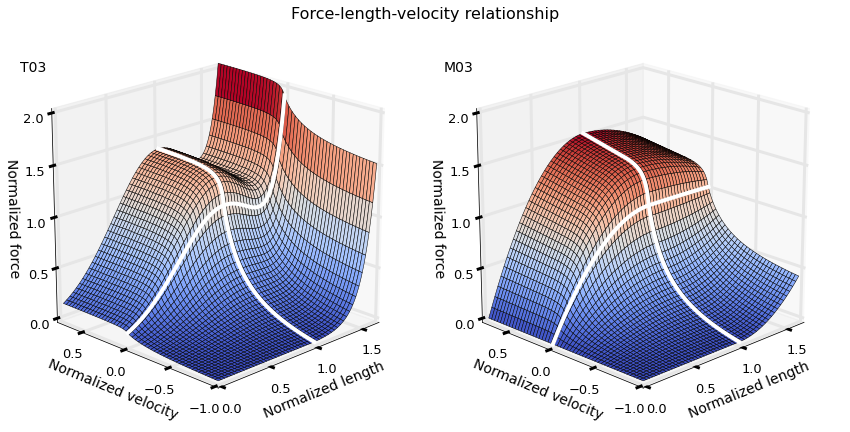

In [28]:
from mpl_toolkits.mplot3d import Axes3D

def flv3dplot(ax, lm, vm, fm, model):
    # 3d plot
    lm2, vm2 = np.meshgrid(lm, vm)
    ax.plot_surface(lm2, vm2, fm, rstride=2, cstride=2, cmap=plt.cm.coolwarm,
                    linewidth=.5, antialiased=True)
    ax.plot(np.ones(vms.size), vms, fm[:, np.argmax(lm>=1)], 'w', linewidth=4)
    ax.plot(lm, np.zeros(lm.size), fm[np.argmax(vm>=0),:], 'w', linewidth=4)
    ax.set_xlim3d(lm[0], lm[-1])
    ax.set_ylim3d(vm[0], vm[-1])
    #ax.set_zlim3d(np.min(fm), np.max(fm))
    ax.set_zlim3d(0, 2)
    ax.set_xlabel('Normalized length')
    ax.set_ylabel('Normalized velocity')
    ax.set_zlabel('Normalized force')
    ax.view_init(20, 225)
    ax.locator_params(nbins=6)
    ax.text(-0.4, 0.7, 2.5, model, fontsize=14)
    
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
flv3dplot(ax1, lms, vms, fm_T03, 'T03')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
flv3dplot(ax2, lms, vms, fm_M03, 'M03')
plt.suptitle('Force-length-velocity relationship', y=1, fontsize=16)
plt.tight_layout()
plt.show()

### Activation dynamics

Activation dynamics represents the fact that a muscle cannot instantly activate or deactivate because of the electrical and chemical processes involved and it is usually integrated with a Hill-type model. In its simplest form, the activation dynamics is generally represented as a first-order ODE.  

Thelen2003Muscle employed the following first-order [ordinary differential equation (ODE)](http://en.wikipedia.org/wiki/Ordinary_differential_equation):

$$ \frac{\mathrm{d}a}{\mathrm{d}t} = \frac{u-a}{\tau(a, u)} $$

with a lower activation bound to both activation and excitation.

where $u$ and $a$ are the muscle excitation and activation, respectively (both are function of time), and $\tau$ is a variable time constant to represent the activation and deactivation times, given by:

$$ 
\tau(a, u) = \left\{ 
  \begin{array}{l l}
    t_{act}(0.5+1.5a) \quad & \text{if} \quad u > a\\
    \frac{t_{deact}}{(0.5+1.5a)} \quad & \text{if} \quad u \leq a
\end{array} \right.
$$

Thelen2003Muscle adopted activation, $t_{act}$, and deactivation, $t_{deact}$, time constants for young adults equal to 15 and 50 ms, respectively (for old adults, Thelen2003Muscle adopted 15 and 60 ms, respectively).

McLean2003Muscle expressed the activation dynamics as the following first-order ODE:

$$ \frac{\mathrm{d}a}{\mathrm{d}t} = (u - a)(c_1u + c_2) $$

with a lower activation bound to both activation and excitation.

where $c_1 + c_2$ is the activation rate constant (when $u = 1$), the inverse of $t_{act}$, and $c_2$ is the deactivation rate constant (when $u = 0$), the inverse of $t_{deact}$.  
McLean2003Muscle adopted $c_1=3.3 s^{-1}$ and $c_2=16.7 s^{-1}$, resulting in time constants of 50 ms and 60 ms for activation and deactivation, respectively.

In Python, the numeric first-order ODE for the activation dynamics presented in Thelen2003Muscle can be expressed as:

In [29]:
def actdyn_T03(t, a, t_act, t_deact, u_max, u_min, t0=0, t1=1):
    """Thelen (2003) activation dynamics, the derivative of `a` at `t`.

    Parameters
    ----------
    t  : float
        time instant [s]
    a  : float (0 <= a <= 1)
        muscle activation
    t_act  : float
        activation time constant [s]
    t_deact  : float
        deactivation time constant [s]
    u_max  : float (0 < u_max <= 1), optional (default=1)
        maximum value for muscle excitation
    u_min  : float (0 < u_min < 1), optional (default=0.01)
        minimum value for muscle excitation
    t0  : float [s], optional (default=0)
        initial time instant for muscle excitation equals to u_max
    t1  : float [s], optional (default=1)
        final time instant for muscle excitation equals to u_max

    Returns
    -------
    adot  : float 
        derivative of `a` at `t`
    """

    u = excitation(t, u_max, u_min)
    if u > a:
        adot = (u - a)/(t_act*(0.5 + 1.5*a))
    else:
        adot = (u - a)/(t_deact/(0.5 + 1.5*a))

    return adot

In Python, the numeric first-order ODE for the activation dynamics presented in McLean2003Muscle can be expressed as:

In [30]:
def actdyn_M03(t, a, t_act, t_deact, u_max=1, u_min=0.01, t0=0, t1=1):
    """McLean (2003) activation dynamics, the derivative of `a` at `t`.

    Parameters
    ----------
    t  : float
        time instant [s]
    a  : float (0 <= a <= 1)
        muscle activation
    t_act  : float
        activation time constant [s]
    t_deact  : float
        deactivation time constant [s]
    u_max  : float (0 < u_max <= 1), optional (default=1)
        maximum value for muscle excitation
    u_min  : float (0 < u_min < 1), optional (default=0.01)
        minimum value for muscle excitation
    t0  : float [s], optional (default=0)
        initial time instant for muscle excitation equals to u_max
    t1  : float [s], optional (default=1)
        final time instant for muscle excitation equals to u_max

    Returns
    -------
    adot  : float 
        derivative of `a` at `t`
    """
    
    c2 = 1/t_deact
    c1 = 1/t_act - c2
    u = excitation(t, u_max, u_min)
    adot = (u - a)*(c1*u + c2)
    
    return adot

Let's simulate the activation signal for a rectangular function as excitation signal:

In [31]:
def excitation(t, u_max=1, u_min=0.01, t0=0.1, t1=0.4):
    """Excitation signal, a square wave.
    
    Parameters
    ----------
    t  : float
        time instant [s]
    u_max  : float (0 < u_max <= 1), optional (default=1)
        maximum value for muscle excitation
    u_min  : float (0 < u_min < 1), optional (default=0.01)
        minimum value for muscle excitation
    t0  : float [s], optional (default=0.1)
        initial time instant for muscle excitation equals to u_max
    t1  : float [s], optional (default=0.4)
        final time instant for muscle excitation equals to u_max

    Returns
    -------
    u  : float (0 < u <= 1)
        excitation signal
    """
    
    u = u_min
    if t >= t0 and t <= t1:
        u = u_max
    
    return u

We will solve the equation for $a$ by numerical integration using the [`scipy.integrate.ode`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.ode.html) class of numeric integrators, particularly the `dopri5`, an explicit runge-kutta method of order (4)5 due to Dormand and Prince (a.k.a. ode45 in Matlab):

In [32]:
import warnings
def actdyn_ode45(fun, t0=0, t1=1, a0=0, t_act=0.015, t_deact=0.050, u_max=1, u_min=0.01):
    # Runge-Kutta (4)5 due to Dormand & Prince with variable stepsize ODE solver
    
    f = ode(fun).set_integrator('dopri5', nsteps=1, max_step=0.01, atol=1e-8)  
    f.set_initial_value(a0, t0).set_f_params(t_act, t_deact, u_max, u_min)
    # suppress Fortran warning
    warnings.filterwarnings("ignore", category=UserWarning)
    data = []
    while f.t < t1:
        f.integrate(t1, step=True)
        data.append([f.t, excitation(f.t, u_max, u_min), np.max([f.y, u_min])])
    warnings.resetwarnings()
    data = np.array(data)
    
    return data

Solving the problem for two different maximum excitation levels:

In [33]:
# using the values for t_act and t_deact from Thelen2003Muscle for both models
act1_T03 = actdyn_ode45(fun=actdyn_T03, u_max=1.0)
act2_T03 = actdyn_ode45(fun=actdyn_T03, u_max=0.5)
act1_M03 = actdyn_ode45(fun=actdyn_M03, u_max=1.0)
act2_M03 = actdyn_ode45(fun=actdyn_M03, u_max=0.5)
# using the values for t_act and t_deact from McLean2003Muscle
act3_M03 = actdyn_ode45(fun=actdyn_M03, u_max=1.0, t_act=0.050, t_deact=0.060)
act4_M03 = actdyn_ode45(fun=actdyn_M03, u_max=0.5, t_act=0.050, t_deact=0.060)

And the results:

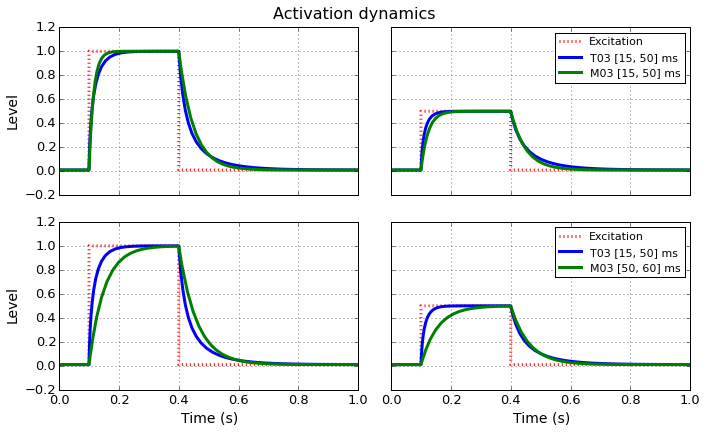

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 6))
axs[0, 0].plot(act1_T03[:, 0], act1_T03[:, 1], 'r:', label='Excitation')
axs[0, 0].plot(act1_T03[:, 0], act1_T03[:, 2], 'b', label='T03 [15, 50] ms')
axs[0, 0].plot(act1_M03[:, 0], act1_M03[:, 2], 'g', label='M03 [15, 50] ms')
axs[0, 0].set_ylabel('Level')
axs[0, 1].plot(act2_T03[:, 0], act2_T03[:, 1], 'r:', label='Excitation')
axs[0, 1].plot(act2_T03[:, 0], act2_T03[:, 2], 'b', label='T03 [15, 50] ms')
axs[0, 1].plot(act2_M03[:, 0], act2_M03[:, 2], 'g', label='M03 [15, 50] ms')
axs[1, 1].set_xlabel('Time (s)')
axs[0, 1].legend()
axs[1, 0].plot(act1_T03[:, 0], act1_T03[:, 1], 'r:', label='Excitation')
axs[1, 0].plot(act1_T03[:, 0], act1_T03[:, 2], 'b', label='T03 [15, 50] ms')
axs[1, 0].plot(act3_M03[:, 0], act3_M03[:, 2], 'g', label='M03 [50, 60] ms')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Level')
axs[1, 1].plot(act2_T03[:, 0], act2_T03[:, 1], 'r:', label='Excitation')
axs[1, 1].plot(act2_T03[:, 0], act2_T03[:, 2], 'b', label='T03 [15, 50] ms')
axs[1, 1].plot(act4_M03[:, 0], act4_M03[:, 2], 'g', label='M03 [50, 60] ms')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].legend()
plt.suptitle('Activation dynamics', y=1, fontsize=16)
plt.tight_layout()
plt.show()

Similar results when the same parameters are used (first row), but different bahavior when the typical values of each study are compared (second row).

### Muscle modeling parameters

We have seen two types of parameters in the muscle modeling: parameters related to the mathematical functions used to model the muscle and tendon behavior and parameters related to the properties of specific muscles and tendons (e.g., maximum isometric force, optimal fiber length, pennation angle, and tendon slack). In general the first type of parameters are independent of the muscle-tendon unit being modeled (but dependent of the model!) while the second type of parameters is changed for each muscle-tendon unit (for instance, see http://isbweb.org/data/delp/ for some of these parameters).

### Limitations of Hill-type muscle models

As with any modeling, Hill-type muscle models are a simplification of the reality. For instance, a typical Hill-type muscle model (as implemented here) does not capture time-dependent muscle behavior, such as force depression after quick muscle shortening, force enhancement after quick muscle lengthening, viscoelastic  properties (creep and relaxation), and muscle fatigue (Zatsiorsky and Prilutsky, 2012). There are enhanced models that capture these properties but it seems their complexity are not worthy for the most common applications of human movement simulation.

## Exercises

1. The results presented in this text depend on the parameters used in the model. These parameters may vary because of different properties of the muscle and tendon but also because different mathematical functions may be used.  
 a. Change some of the parameters and reproduce the plots shown here and discuss these results (e.g., use the parameters for different muscles from OpenSim or the data from [http://isbweb.org/data/delp/](http://isbweb.org/data/delp/)).  
 b. Select another reference (e.g., Anderson, 2007) about muscle modeling that uses different mathematical functions and repeat the previous item.

## References

- Anderson C (2007) [Equations for Modeling the Forces Generated by Muscles and Tendons](https://docs.google.com/viewer?url=https%3A%2F%2Fsimtk.org%2Fdocman%2Fview.php%2F124%2F604%2FMuscleAndTendonForcesClayAnderson20070521.doc) ([PDF](https://drive.google.com/open?id=0BxbW72zV7WmUVUh0MldGOGZ6aHc&authuser=0)). BioE215 Physics-based Simulation of Biological Structures.  
- Erdemir A, McLean S, Herzog W, van den Bogert AJ (2007) [Model-based estimation of muscle forces exerted during movements](http://www.ncbi.nlm.nih.gov/pubmed/17070969). Clinical Biomechanics, 22, 131–154. 
- He J, Levine WS, Loeb GE (1991) [Feedback gains for correcting small perturbations to standing posture](https://drive.google.com/open?id=0BxbW72zV7WmUekRXY09GSEhUVlE&authuser=0). IEEE Transactions on Automatic Control, 36, 322–332.  
- McLean SG, Su A, van den Bogert AJ (2003) [Development and validation of a 3-D model to predict knee joint loading during dynamic movement](http://www.ncbi.nlm.nih.gov/pubmed/14986412). Journal of Biomechanical Engineering, 125, 864-74.  
- McMahon TA (1984) [Muscles, Reflexes, and Locomotion](https://archive.org/details/McMahonTAMusclesReflexesAndLocomotionPrincetonUniversityPress1984). Princeton University Press, Princeton, New Jersey.  
- Millard M, Uchida T, Seth A, Delp SL (2013) [Flexing computational muscle: modeling and simulation of musculotendon dynamics](http://www.ncbi.nlm.nih.gov/pubmed/23445050). Journal of Biomechanical Engineering, 135, 021005.  
- Nigg BM and Herzog W (2006) [Biomechanics of the Musculo-skeletal System](https://books.google.com.br/books?id=hOIeAQAAIAAJ&dq=editions:ISBN0470017678). 3rd Edition. Wiley.  
- Robertson G, Caldwell G, Hamill J, Kamen G (2013) [Research Methods in Biomechanics](http://books.google.com.br/books?id=gRn8AAAAQBAJ). 2nd Edition. Human Kinetics.  
- Thelen DG (2003) [Adjustment of muscle mechanics model parameters to simulate dynamic contractions in older adults](http://homepages.cae.wisc.edu/~thelen/pubs/jbme03.pdf). Journal of Biomechanical Engineering, 125(1):70–77.
- Tsianos GA and Loeb GE (2013) [Muscle Physiology and Modeling](http://www.scholarpedia.org/article/Muscle_Physiology_and_Modeling). Scholarpedia, 8(10):12388.   
- Winters JM (1990) [Hill-based muscle models: a systems engineering perspective](http://link.springer.com/chapter/10.1007%2F978-1-4613-9030-5_5). In [Multiple Muscle Systems: Biomechanics and Movement Organization](http://link.springer.com/book/10.1007/978-1-4613-9030-5), edited by JM Winters and SL Woo, Springer-Verlag, New York.  
- Winters JM (1995) [An Improved Muscle-Reflex Actuator for Use in Large-Scale Neuromusculoskeletal Models](http://www.ncbi.nlm.nih.gov/pubmed/7486344). Annals of Biomedical Engineering, 23, 359–374.  
- Zajac FE (1989) [Muscle and tendon: properties, models, scaling and application to biomechanics and motor control](http://www.ncbi.nlm.nih.gov/pubmed/2676342). Critical Reviews in Biomedical Engineering 17:359-411.  
- Zatsiorsky V and Prilutsky B (2012) [Biomechanics of Skeletal Muscles](http://books.google.com.br/books?id=THXfHT8L5MEC). Human Kinetics.  